In [ ]:
import copy
import datetime as dt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
import math
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


<h2>Load Data</h2>

In [ ]:
weather_data = pd.read_csv('/content/drive/MyDrive/softcom/main22.csv')

In [ ]:
weather_data

In [ ]:
weather_data = weather_data[['date', 'station', 'max_temp', 'min_temp', 'rainfall', 'cloud', 'humidity', 'wind_speed', 'sunshine']]
dhaka = weather_data[weather_data['station'] == 'Dhaka']
raj = weather_data[weather_data['station'] == 'Rajshahi']
khulna = weather_data[weather_data['station'] == 'Khulna']
mymen = weather_data[weather_data['station'] == 'Mymensingh']
chitt = weather_data[weather_data['station'] == 'Chittagong']
syl = weather_data[weather_data['station'] == 'Sylhet']
rang = weather_data[weather_data['station'] == 'Rangpur']
bar = weather_data[weather_data['station'] == 'Barisal']

In [ ]:
dhaka['date'] = pd.to_datetime(dhaka['date'])
raj['date'] = pd.to_datetime(raj['date'])
khulna['date'] = pd.to_datetime(khulna['date'])
mymen['date'] = pd.to_datetime(mymen['date'])
chitt['date'] = pd.to_datetime(chitt['date'])
syl['date'] = pd.to_datetime(syl['date'])
rang['date'] = pd.to_datetime(rang['date'])
bar['date'] = pd.to_datetime(bar['date'])

In [ ]:
dhaka

,date,station,max_temp,min_temp,rainfall,cloud,humidity,wind_speed,sunshine
0,1953-01-01,Dhaka,25.18,10.92,10,1.65,70.48,1.433178,6.427503
1,1953-02-01,Dhaka,29.52,14.74,2,2.07,64.50,1.433178,6.427503
2,1953-03-01,Dhaka,32.65,21.70,90,3.74,73.48,1.433178,6.427503
3,1953-04-01,Dhaka,35.02,23.44,90,3.37,68.83,1.433178,6.427503
4,1953-05-01,Dhaka,32.77,24.19,274,5.84,80.74,1.433178,6.427503
...,...,...,...,...,...,...,...,...,...
835,2022-08-01,Dhaka,34.21,27.36,130,5.45,75.03,3.100000,5.400000
836,2022-09-01,Dhaka,33.21,26.68,282,5.80,80.97,2.240000,3.640000
837,2022-10-01,Dhaka,32.72,24.91,297,3.71,73.97,2.220000,5.510000
838,2022-11-01,Dhaka,31.04,20.77,0,1.70,63.77,2.050000,5.990000


In [ ]:
dhaka.shape

(840, 9)

In [ ]:
raj.shape

(708, 7)

In [ ]:
khulna.shape

(876, 7)

In [ ]:
mymen.shape

(876, 7)

In [ ]:
chitt.shape

(876, 7)

In [ ]:
syl.shape

(804, 7)

In [ ]:
rang.shape

(792, 7)

In [ ]:
bar.shape

(876, 7)

In [ ]:

TRAIN_TEST_SPLIT_DATE = '2000-01-01'
TRAIN_VALIDATION_SPLIT_DATE = '1980-01-01'

<h1>EDA Plot</h1>

In [ ]:
# time series plot of each feature over time
for city in [dhaka,raj,khulna,mymen,rang,syl,chitt,bar]:
    print(city['station'].iloc[0])
    values = city.values

    groups = [2, 3, 4, 5, 6, 7, 8]
    i = 1

    plt.figure()
    for group in groups:
        plt.subplot(len(groups), 1, i)
        plt.plot(values[:, group])
        plt.title(city.columns[group], y=0.5, loc='right')
        i += 1
    plt.show()

<h2>Scaling the Data and Supervised Data</h2>

In [ ]:
# This function is taken from https://machinelearningmastery.com/convert-time-series-supervised-learning-problem-python/
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    """
    Frame a time series as a supervised learning dataset.
    Arguments:
        data: Sequence of observations as a list or NumPy array.
        n_in: Number of lag observations as input (X).
        n_out: Number of observations as output (y).
        dropnan: Boolean whether or not to drop rows with NaN values.
    Returns:
        Pandas DataFrame of series framed for supervised learning.
    """
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data).astype(float)  # Convert the DataFrame to float
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [ ]:
dhaka = dhaka.set_index('date').drop(columns=['station'])
raj = raj.set_index('date').drop(columns=['station'])
khulna = khulna.set_index('date').drop(columns=['station'])
mymen = mymen.set_index('date').drop(columns=['station'])
chitt = chitt.set_index('date').drop(columns=['station'])
syl = syl.set_index('date').drop(columns=['station'])
rang = rang.set_index('date').drop(columns=['station'])
bar = bar.set_index('date').drop(columns=['station'])

In [ ]:
# transform daily weather data into supervised data, with 1 day's data used to make predictions
def make_supervised(data_scaled, data):
    data_sup = series_to_supervised(data_scaled, n_in=7, n_out=1)  # Set n_out to 1
    drop_cols = ['var2(t)', 'var3(t)', 'var4(t)', 'var5(t)', 'var6(t)', 'var7(t)']

    # add future day cols to drop_cols for 1 day output
    for t in range(1, 1):  # Adjust the range for 1 day output
        for feat in range(1, 7):
            drop_cols.append(f'var{feat}(t+{t-1})')  # Adjust the column names accordingly

    data_sup = data_sup.drop(columns=drop_cols)
    # Uncomment the following line if needed, and check if it affects the length
    # data_sup = data_sup.set_index(data.index[13:])

    # Ensure the resulting DataFrame has the expected length
    if len(data_sup) != len(data) - 13:  # Adjust if necessary based on your data and indexing
        print(f"Length mismatch: Expected {len(data) - 13} rows, received {len(data_sup)}")

    return data_sup

In [ ]:
# transform daily weather data into supervised data, with 1 week's data used to make predictions
def make_supervised(data_scaled, data):
    data_sup = series_to_supervised(data_scaled, n_in=7, n_out=7)
    drop_cols = ['var2(t)', 'var3(t)', 'var4(t)', 'var5(t)','var6(t)','var7(t)']
    # add future day cols to drop_cols
    for t in range(1, 7):
        for feat in range(1, 7):
            # don't drop predicted max temp 1 week from current day, else drop
            if not (feat == 1):
                drop_cols.append(f'var{feat}(t+{t})')
    data_sup = data_sup.drop(columns=drop_cols)
    #data_sup = data_sup.set_index(data.index[7:])
    data_sup = data_sup.set_index(data.index[13:])
    return data_sup

In [ ]:
dhaka_vals, raj_vals, khulna_vals, mymen_vals = dhaka.values, raj.values, khulna.values, mymen.values

dhaka_scaler, raj_scaler, khulna_scaler, mymen_scaler = MinMaxScaler(feature_range=(0, 1)), MinMaxScaler(feature_range=(0, 1)), MinMaxScaler(feature_range=(0, 1)), MinMaxScaler(feature_range=(0,1))

dhaka_scaled, raj_scaled, khulna_scaled, mymen_scaled = dhaka_scaler.fit_transform(dhaka_vals), raj_scaler.fit_transform(raj_vals), khulna_scaler.fit_transform(khulna_vals), mymen_scaler.fit_transform(mymen_vals)


dhaka_sup = make_supervised(dhaka_scaled, dhaka)
raj_sup = make_supervised(raj_scaled, raj)
khulna_sup = make_supervised(khulna_scaled, khulna)
mymen_sup = make_supervised(mymen_scaled, mymen)

Length mismatch: Expected 827 rows, received 833
Length mismatch: Expected 695 rows, received 701
Length mismatch: Expected 863 rows, received 869
Length mismatch: Expected 863 rows, received 869


In [ ]:
chitt_vals, syl_vals, rang_vals, bar_vals = chitt.values, syl.values, rang.values, bar.values

chitt_scaler, syl_scaler, rang_scaler, bar_scaler = MinMaxScaler(feature_range=(0, 1)), MinMaxScaler(feature_range=(0, 1)), MinMaxScaler(feature_range=(0, 1)), MinMaxScaler(feature_range=(0,1))

chitt_scaled, syl_scaled, rang_scaled, bar_scaled = chitt_scaler.fit_transform(chitt_vals), syl_scaler.fit_transform(syl_vals), rang_scaler.fit_transform(rang_vals), bar_scaler.fit_transform(bar_vals)


chitt_sup = make_supervised(chitt_scaled, chitt)
syl_sup = make_supervised(syl_scaled, syl)
rang_sup = make_supervised(rang_scaled, rang)
bar_sup = make_supervised(bar_scaled, bar)

Length mismatch: Expected 863 rows, received 869
Length mismatch: Expected 791 rows, received 797
Length mismatch: Expected 779 rows, received 785
Length mismatch: Expected 863 rows, received 869


<h2>Split data into train, validation, and test data</h2>

In [ ]:
dhaka_train, dhaka_validation, dhaka_test = dhaka_sup.loc[:TRAIN_VALIDATION_SPLIT_DATE], dhaka_sup.loc[TRAIN_VALIDATION_SPLIT_DATE:TRAIN_TEST_SPLIT_DATE], dhaka_sup.loc[TRAIN_TEST_SPLIT_DATE:]
raj_train, raj_validation, raj_test = raj_sup.loc[:TRAIN_VALIDATION_SPLIT_DATE], raj_sup.loc[TRAIN_VALIDATION_SPLIT_DATE:TRAIN_TEST_SPLIT_DATE], raj_sup.loc[TRAIN_TEST_SPLIT_DATE:]
khulna_train, khulna_validation, khulna_test = khulna_sup.loc[:TRAIN_VALIDATION_SPLIT_DATE], khulna_sup.loc[TRAIN_VALIDATION_SPLIT_DATE:TRAIN_TEST_SPLIT_DATE], khulna_sup.loc[TRAIN_TEST_SPLIT_DATE:]
mymen_train, mymen_validation, mymen_test = mymen_sup.loc[:TRAIN_VALIDATION_SPLIT_DATE], mymen_sup.loc[TRAIN_VALIDATION_SPLIT_DATE:TRAIN_TEST_SPLIT_DATE], mymen_sup.loc[TRAIN_TEST_SPLIT_DATE:]

In [ ]:
chitt_train, chitt_validation, chitt_test = chitt_sup.loc[:TRAIN_VALIDATION_SPLIT_DATE], chitt_sup.loc[TRAIN_VALIDATION_SPLIT_DATE:TRAIN_TEST_SPLIT_DATE], chitt_sup.loc[TRAIN_TEST_SPLIT_DATE:]
syl_train, syl_validation, syl_test = syl_sup.loc[:TRAIN_VALIDATION_SPLIT_DATE], syl_sup.loc[TRAIN_VALIDATION_SPLIT_DATE:TRAIN_TEST_SPLIT_DATE], syl_sup.loc[TRAIN_TEST_SPLIT_DATE:]
rang_train, rang_validation, rang_test = rang_sup.loc[:TRAIN_VALIDATION_SPLIT_DATE], rang_sup.loc[TRAIN_VALIDATION_SPLIT_DATE:TRAIN_TEST_SPLIT_DATE], rang_sup.loc[TRAIN_TEST_SPLIT_DATE:]
bar_train, bar_validation, bar_test = bar_sup.loc[:TRAIN_VALIDATION_SPLIT_DATE], bar_sup.loc[TRAIN_VALIDATION_SPLIT_DATE:TRAIN_TEST_SPLIT_DATE], bar_sup.loc[TRAIN_TEST_SPLIT_DATE:]

In [ ]:
dhaka_train

,var1(t-7),var2(t-7),var3(t-7),var4(t-7),var5(t-7),var6(t-7),var7(t-7),var1(t-6),var2(t-6),var3(t-6),...,var6(t-2),var7(t-2),var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var1(t)
7,0.232179,0.077129,0.011682,0.218077,0.529831,0.345984,0.521605,0.526816,0.281735,0.002336,...,0.345984,0.521605,0.615750,0.853776,0.457944,0.935438,0.982077,0.345984,0.521605,0.653768
8,0.526816,0.281735,0.002336,0.278336,0.383010,0.345984,0.521605,0.739308,0.654526,0.105140,...,0.345984,0.521605,0.653768,0.869845,0.380841,0.925395,0.899828,0.345984,0.521605,0.670061
9,0.739308,0.654526,0.105140,0.517934,0.603486,0.345984,0.521605,0.900204,0.747724,0.105140,...,0.345984,0.521605,0.670061,0.857525,0.411215,0.909613,0.940339,0.345984,0.521605,0.625933
10,0.900204,0.747724,0.105140,0.464849,0.489320,0.345984,0.521605,0.747454,0.787895,0.320093,...,0.345984,0.521605,0.625933,0.717729,0.060748,0.476327,0.772158,0.345984,0.521605,0.467074
11,0.747454,0.787895,0.320093,0.819225,0.781733,0.345984,0.521605,0.651731,0.838243,0.389019,...,0.345984,0.521605,0.467074,0.412426,0.015187,0.272597,0.650626,0.345984,0.521605,0.408011
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
194,0.636796,0.892341,0.247664,0.879484,0.887798,0.431472,0.416386,0.708758,0.909480,0.149533,...,0.215736,0.831650,0.503055,0.259775,0.001168,0.176471,0.276946,0.218274,0.762065,0.741344
195,0.708758,0.909480,0.149533,0.760402,0.820034,0.307107,0.475870,0.597420,0.762721,0.080607,...,0.218274,0.762065,0.741344,0.594001,0.075935,0.374462,0.406334,0.421320,0.683502,0.830278
196,0.597420,0.762721,0.080607,0.505022,0.761110,0.230964,0.548822,0.473863,0.492769,0.086449,...,0.421320,0.683502,0.830278,0.752544,0.100467,0.497848,0.555610,0.571066,0.717172,0.824168
197,0.473863,0.492769,0.086449,0.368723,0.626074,0.187817,0.736251,0.258656,0.226031,0.000000,...,0.571066,0.717172,0.824168,0.853776,0.110981,0.509326,0.625829,0.324873,0.883277,0.654447


In [ ]:
# return x_data, [y_data_1_day_ahead, y_data_2_days_ahead, ... y_data_7_days_ahead]
def x_y_split(data):
    y_data = []
    y_cols = ['var1(t)', 'var1(t+1)', 'var1(t+2)', 'var1(t+3)', 'var1(t+4)', 'var1(t+5)', 'var1(t+6)']
    x_data = data.drop(columns=y_cols)
    for col in y_cols:
        y_data.append(data[[col]].values)
    return x_data, y_data

In [ ]:
# return x_data, [y_data1_days_ahead]
def x_y_split(data):
    y_data = []
    y_cols = ['var1(t)']
    x_data = data.drop(columns=y_cols)
    for col in y_cols:
        y_data.append(data[[col]].values)
    return x_data, y_data

In [ ]:
x_train_dhaka, y_train_dhaka = x_y_split(dhaka_train)
x_validation_dhaka, y_validation_dhaka = x_y_split(dhaka_validation)
x_test_dhaka, y_test_dhaka = x_y_split(dhaka_test)

x_train_raj, y_train_raj = x_y_split(raj_train)
x_validation_raj, y_validation_raj = x_y_split(raj_validation)
x_test_raj, y_test_raj = x_y_split(raj_test)

x_train_khulna, y_train_khulna = x_y_split(khulna_train)
x_validation_khulna, y_validation_khulna = x_y_split(khulna_validation)
x_test_khulna, y_test_khulna = x_y_split(khulna_test)

x_train_mymen, y_train_mymen = x_y_split(mymen_train)
x_validation_mymen, y_validation_mymen = x_y_split(mymen_validation)
x_test_mymen, y_test_mymen = x_y_split(mymen_test)

In [ ]:
x_train_chitt, y_train_chitt = x_y_split(chitt_train)
x_validation_chitt, y_validation_chitt = x_y_split(chitt_validation)
x_test_chitt, y_test_chitt = x_y_split(chitt_test)

x_train_syl, y_train_syl = x_y_split(syl_train)
x_validation_syl, y_validation_syl = x_y_split(syl_validation)
x_test_syl, y_test_syl = x_y_split(syl_test)

x_train_rang, y_train_rang = x_y_split(rang_train)
x_validation_rang, y_validation_rang = x_y_split(rang_validation)
x_test_rang, y_test_rang = x_y_split(rang_test)

x_train_bar, y_train_bar = x_y_split(bar_train)
x_validation_bar, y_validation_bar = x_y_split(bar_validation)
x_test_bar, y_test_bar = x_y_split(bar_test)

<h2>Reshape Data</h2>
We need to reshape the x data so that it can be passed in to the LSTM properly. Instead of passing a list of all of the features on each day to the model, we need to pass a list whose items are 7 x 5 arrays of all of my features. Each of these 7 x 5 arrays has 7 rows of features, with each row including the values of my features n days before the day we're making the prediction on.

In [ ]:
# reshape into (num_days, num_timesteps, num_features)
def reshape_data(x_train, x_validation, x_test):
    x_train = x_train.values.reshape((x_train.values.shape[0], 7,7))
    x_validation = x_validation.values.reshape((x_validation.values.shape[0], 7,7))
    x_test = x_test.values.reshape((x_test.values.shape[0], 7, 7))
    return x_train, x_validation, x_test

In [ ]:
x_train_dhaka, x_validation_dhaka, x_test_dhaka = reshape_data(x_train_dhaka, x_validation_dhaka, x_test_dhaka)
x_train_raj, x_validation_raj, x_test_raj = reshape_data(x_train_raj, x_validation_raj, x_test_raj)
x_train_khulna, x_validation_khulna, x_test_khulna = reshape_data(x_train_khulna, x_validation_khulna, x_test_khulna)
x_train_mymen, x_validation_mymen, x_test_mymen = reshape_data(x_train_mymen, x_validation_mymen, x_test_mymen)

In [ ]:
x_train_chitt, x_validation_chitt, x_test_chitt = reshape_data(x_train_chitt, x_validation_chitt, x_test_chitt)
x_train_syl, x_validation_syl, x_test_syl = reshape_data(x_train_syl, x_validation_syl, x_test_syl)
x_train_rang, x_validation_rang, x_test_rang = reshape_data(x_train_rang, x_validation_rang, x_test_rang)
x_train_bar, x_validation_bar, x_test_bar = reshape_data(x_train_bar, x_validation_bar, x_test_bar)

<h2>Fit LSTM Models</h2>
Next, we fit an LSTM model for each day ahead (up to 7 days ahead) we are predicting in each of the four cities we are making predictions for.

In [ ]:
def fit_lstm(model_name, x_train, y_train, x_validation, y_validation):
    model = Sequential()
    # 50 neurons in first layer
    model.add(LSTM(50, input_shape=(7, 7)))
    model.add(Dense(1))
    model.compile(loss='mae', optimizer='adam')
    history = model.fit(x_train, y_train, epochs=50, batch_size=72, validation_data=(x_validation, y_validation), verbose=0, shuffle=False)
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='validation')
    plt.title(f"{model_name} Model Performance")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()
    return model

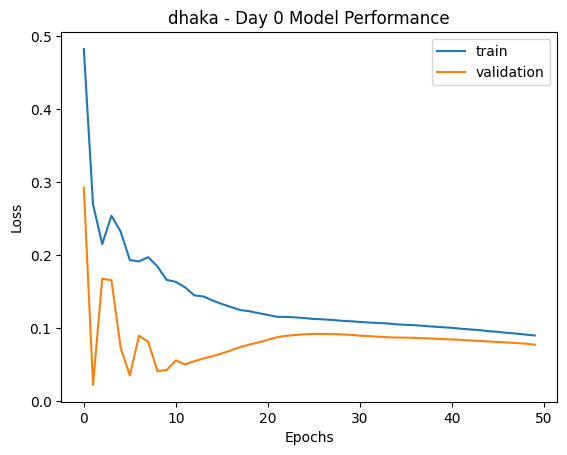

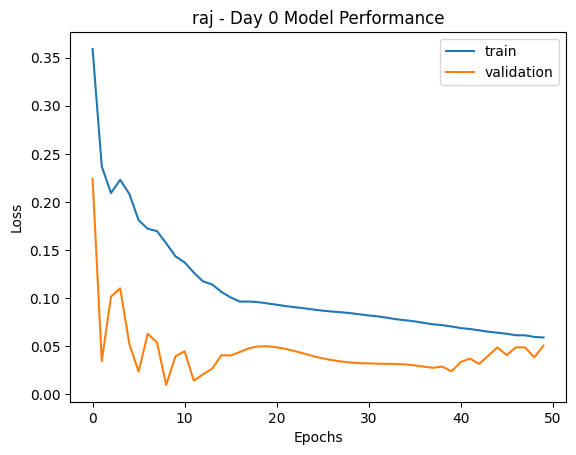

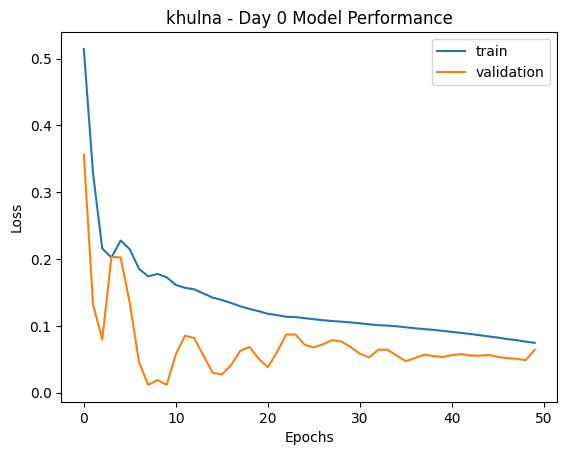

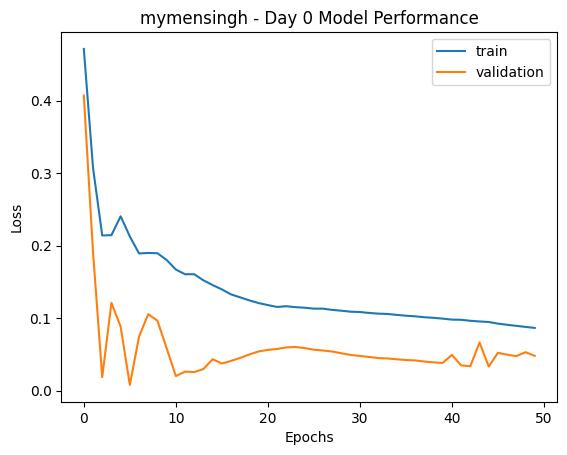

In [ ]:
dhaka_models = [fit_lstm(f'dhaka - Day {i}', x_train_dhaka, y_train_day_i, x_validation_dhaka, y_validation_day_i)
                    for i, (y_train_day_i, y_validation_day_i) in enumerate(zip(y_train_dhaka, y_validation_dhaka))]
raj_models = [fit_lstm(f'raj - Day {i}', x_train_raj, y_train_day_i, x_validation_raj, y_validation_day_i)
                    for i, (y_train_day_i, y_validation_day_i) in enumerate(zip(y_train_raj, y_validation_raj))]
khulna_models = [fit_lstm(f'khulna - Day {i}', x_train_khulna, y_train_day_i, x_validation_khulna, y_validation_day_i)
                    for i, (y_train_day_i, y_validation_day_i) in enumerate(zip(y_train_khulna, y_validation_khulna))]
mymen_models = [fit_lstm(f'mymensingh - Day {i}', x_train_mymen, y_train_day_i, x_validation_mymen, y_validation_day_i)
                    for i, (y_train_day_i, y_validation_day_i) in enumerate(zip(y_train_mymen, y_validation_mymen))]


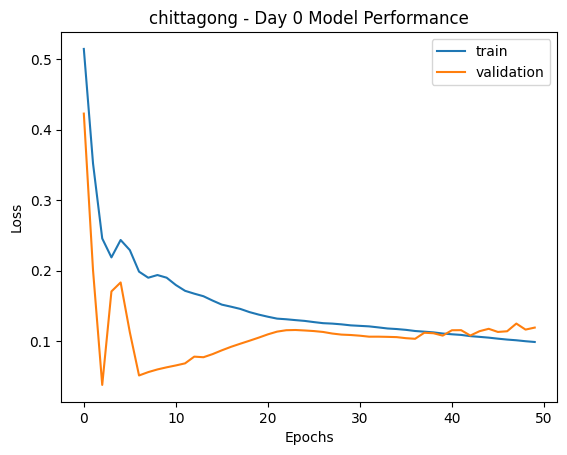

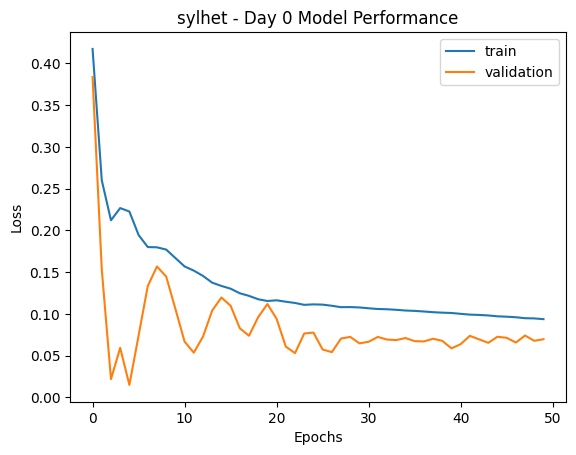

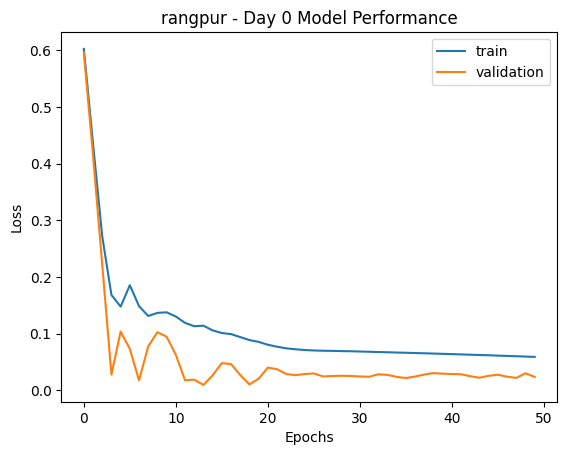

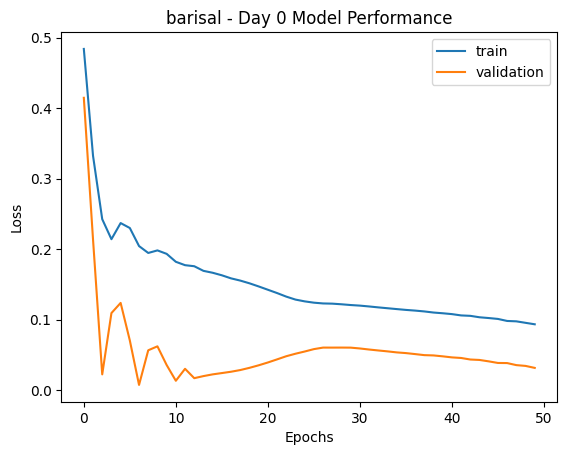

In [ ]:
chitt_models = [fit_lstm(f'chittagong - Day {i}', x_train_chitt, y_train_day_i, x_validation_chitt, y_validation_day_i)
                    for i, (y_train_day_i, y_validation_day_i) in enumerate(zip(y_train_chitt, y_validation_chitt))]
syl_models = [fit_lstm(f'sylhet - Day {i}', x_train_syl, y_train_day_i, x_validation_syl, y_validation_day_i)
                    for i, (y_train_day_i, y_validation_day_i) in enumerate(zip(y_train_syl, y_validation_syl))]
rang_models = [fit_lstm(f'rangpur - Day {i}', x_train_rang, y_train_day_i, x_validation_rang, y_validation_day_i)
                    for i, (y_train_day_i, y_validation_day_i) in enumerate(zip(y_train_rang, y_validation_rang))]
bar_models = [fit_lstm(f'barisal - Day {i}', x_train_bar, y_train_day_i, x_validation_bar, y_validation_day_i)
                    for i, (y_train_day_i, y_validation_day_i) in enumerate(zip(y_train_bar, y_validation_bar))]


<h2>Make Predictions</h2>

In [ ]:
y_pred_train_dhaka = [dhaka_model.predict(x_train_dhaka) for dhaka_model in dhaka_models]
y_pred_validation_dhaka = [dhaka_model.predict(x_validation_dhaka) for dhaka_model in dhaka_models]
y_pred_test_dhaka = [dhaka_model.predict(x_test_dhaka) for dhaka_model in dhaka_models]

y_pred_train_raj = [raj_model.predict(x_train_raj) for raj_model in raj_models]
y_pred_validation_raj = [raj_model.predict(x_validation_raj) for raj_model in raj_models]
y_pred_test_raj = [raj_model.predict(x_test_raj) for raj_model in raj_models]

y_pred_train_khulna = [khulna_model.predict(x_train_khulna) for khulna_model in khulna_models]
y_pred_validation_khulna = [khulna_model.predict(x_validation_khulna) for khulna_model in khulna_models]
y_pred_test_khulna = [khulna_model.predict(x_test_khulna) for khulna_model in khulna_models]

y_pred_train_mymen = [mymen_model.predict(x_train_mymen) for mymen_model in mymen_models]
y_pred_validation_mymen = [mymen_model.predict(x_validation_mymen) for mymen_model in mymen_models]
y_pred_test_mymen = [mymen_model.predict(x_test_mymen) for mymen_model in mymen_models]

22/22 [==============================] - 0s 3ms/step


In [ ]:
y_pred_train_chitt = [chitt_model.predict(x_train_chitt) for chitt_model in chitt_models]
y_pred_validation_chitt = [chitt_model.predict(x_validation_chitt) for chitt_model in chitt_models]
y_pred_test_chitt = [chitt_model.predict(x_test_chitt) for chitt_model in chitt_models]

y_pred_train_syl = [syl_model.predict(x_train_syl) for syl_model in syl_models]
y_pred_validation_syl = [syl_model.predict(x_validation_syl) for syl_model in syl_models]
y_pred_test_syl = [syl_model.predict(x_test_syl) for syl_model in syl_models]

y_pred_train_rang = [rang_model.predict(x_train_rang) for rang_model in rang_models]
y_pred_validation_rang = [rang_model.predict(x_validation_rang) for rang_model in rang_models]
y_pred_test_rang = [rang_model.predict(x_test_rang) for rang_model in rang_models]

y_pred_train_bar = [bar_model.predict(x_train_bar) for bar_model in bar_models]
y_pred_validation_bar = [bar_model.predict(x_validation_bar) for bar_model in bar_models]
y_pred_test_bar = [bar_model.predict(x_test_bar) for bar_model in bar_models]

22/22 [==============================] - 0s 3ms/step


<h2>Unscale Predictions</h2>

In [ ]:
import numpy as np

def unscale_y_values(y_vals_list, city_data, city_scaler):
    y_vals_unscaled_tup = ()
    for y_vals_city in y_vals_list:
        y_unscaled_by_day = []
        for y_vals_day_i in y_vals_city:
            rescaling_city_data = city_data.copy()[:len(y_vals_day_i)]  # Ensure lengths match by truncating DataFrame
            rescaling_city_data['max_temp'] = y_vals_day_i  # Assuming 'MaxTemp' is the target column in your dataset
            # Inverse transforming the scaled values back to original scale
            unscaled_values = city_scaler.inverse_transform(rescaling_city_data)
            y_unscaled = unscaled_values[:, city_data.columns.get_loc('max_temp')]  # Extracting unscaled MaxTemp values
            y_unscaled_by_day.append(y_unscaled)
        y_vals_unscaled_tup = y_vals_unscaled_tup + (y_unscaled_by_day,)
    return y_vals_unscaled_tup



In [ ]:
y_pred_train_dhaka_unscaled, y_train_dhaka_unscaled,\
y_pred_validation_dhaka_unscaled, y_validation_dhaka_unscaled,\
y_pred_test_dhaka_unscaled, y_test_dhaka_unscaled \
        = unscale_y_values([y_pred_train_dhaka, y_train_dhaka,
                            y_pred_validation_dhaka, y_validation_dhaka,
                            y_pred_test_dhaka, y_test_dhaka], dhaka, dhaka_scaler)

y_pred_train_raj_unscaled, y_train_raj_unscaled, \
y_pred_validation_raj_unscaled, y_validation_raj_unscaled, \
y_pred_test_raj_unscaled, y_test_raj_unscaled\
        = unscale_y_values([y_pred_train_raj, y_train_raj,
                            y_pred_validation_raj, y_validation_raj,
                            y_pred_test_raj, y_test_raj], raj, raj_scaler)

y_pred_train_khulna_unscaled, y_train_khulna_unscaled,\
y_pred_validation_khulna_unscaled, y_validation_khulna_unscaled,\
y_pred_test_khulna_unscaled, y_test_khulna_unscaled \
        = unscale_y_values([y_pred_train_khulna, y_train_khulna,
                            y_pred_validation_khulna, y_validation_khulna,
                            y_pred_test_khulna, y_test_khulna], khulna, khulna_scaler)

y_pred_train_mymen_unscaled, y_train_mymen_unscaled,\
y_pred_validation_mymen_unscaled, y_validation_mymen_unscaled, \
y_pred_test_mymen_unscaled, y_test_mymen_unscaled\
        = unscale_y_values([y_pred_train_mymen, y_train_mymen,
                            y_pred_validation_mymen, y_validation_mymen,
                            y_pred_test_mymen, y_test_mymen], mymen, mymen_scaler)

In [ ]:
y_pred_train_chitt_unscaled, y_train_chitt_unscaled,\
y_pred_validation_chitt_unscaled, y_validation_chitt_unscaled,\
y_pred_test_chitt_unscaled, y_test_chitt_unscaled\
        = unscale_y_values([y_pred_train_chitt, y_train_chitt,
                            y_pred_validation_chitt, y_validation_chitt,
                            y_pred_test_chitt, y_test_chitt], chitt, chitt_scaler)

y_pred_train_syl_unscaled, y_train_syl_unscaled,\
y_pred_validation_syl_unscaled, y_validation_syl_unscaled,\
y_pred_test_syl_unscaled, y_test_syl_unscaled\
        = unscale_y_values([y_pred_train_syl, y_train_syl,
                            y_pred_validation_syl, y_validation_syl,
                            y_pred_test_syl, y_test_syl], syl, syl_scaler)

y_pred_train_rang_unscaled, y_train_rang_unscaled,\
y_pred_validation_rang_unscaled, y_validation_rang_unscaled,\
y_pred_test_rang_unscaled, y_test_rang_unscaled \
        = unscale_y_values([y_pred_train_rang, y_train_rang,
                            y_pred_validation_rang, y_validation_rang,
                            y_pred_test_rang, y_test_rang], rang, rang_scaler)

y_pred_train_bar_unscaled, y_train_bar_unscaled, \
y_pred_validation_bar_unscaled, y_validation_bar_unscaled,\
y_pred_test_bar_unscaled, y_test_bar_unscaled \
        = unscale_y_values([y_pred_train_bar, y_train_bar,
                            y_pred_validation_bar, y_validation_bar,
                            y_pred_test_bar, y_test_bar], bar, bar_scaler)

In [ ]:
y_pred_train_dhaka_unscaled

[array([30.82300551, 30.2254495 , 29.25785627, 27.97375693, 26.63473052,
        26.92964367, 27.95605605, 29.99886398, 31.52521895, 32.53921762,
        32.44883259, 31.96462947, 31.07590838, 30.36148316, 29.08732954,
        27.30027878, 25.70570328, 25.56221165, 27.89345458, 29.37304063,
        31.22289655, 31.71502604, 32.00560199, 31.64105126, 31.22463144,
        30.50170653, 29.60326361, 28.45719094, 27.2848444 , 26.79912809,
        27.68831758, 29.73518044, 31.24241309, 31.76431652, 31.55316231,
        31.18897594, 30.6203229 , 29.87431161, 28.66988688, 27.64162285,
        26.23690579, 25.77974216, 27.20103321, 28.71370448, 30.59407492,
        31.75671587, 31.86304145, 31.58018818, 30.95341837, 30.44247034,
        29.9527667 , 28.89402504, 27.89492431, 27.74081267, 29.40654158,
        30.98136524, 31.89532377, 32.48538538, 32.28299864, 31.91427664,
        31.39397904, 30.88661052, 30.44887606, 29.47178752, 28.31024974,
        28.15204146, 28.57456981, 29.72547617, 31.2

In [ ]:
y_train_dhaka_unscaled

[array([31.39, 31.63, 30.98, 28.64, 27.77, 24.8 , 30.55, 34.8 , 34.47,
        33.48, 30.13, 30.96, 31.03, 31.42, 29.81, 27.76, 25.76, 25.08,
        28.52, 32.9 , 33.32, 32.96, 31.58, 30.55, 30.62, 31.64, 31.22,
        28.36, 25.1 , 25.42, 28.08, 32.1 , 33.96, 32.1 , 29.98, 30.61,
        30.81, 30.52, 31.13, 28.41, 26.19, 24.7 , 26.36, 31.79, 35.48,
        34.07, 32.08, 30.72, 31.7 , 31.93, 31.16, 29.52, 26.81, 27.25,
        28.19, 33.27, 35.18, 33.38, 32.91, 31.32, 30.98, 31.86, 31.33,
        29.42, 26.57, 25.28, 27.45, 32.5 , 33.78, 32.97, 31.34, 30.79,
        30.67, 30.11, 29.11, 27.96, 25.9 , 25.53, 31.24, 32.05, 34.98,
        33.45, 31.9 , 30.4 , 31.42, 30.96, 30.84, 27.98, 26.11, 25.98,
        25.36, 33.06, 33.76, 32.1 , 30.49, 30.98, 30.75, 30.65, 30.33,
        27.92, 24.54, 25.  , 28.91, 34.42, 34.82, 32.5 , 31.11, 31.59,
        30.72, 31.62, 30.33, 28.45, 25.62, 25.39, 30.44, 33.35, 33.44,
        31.72, 31.16, 31.05, 31.14, 31.83, 30.5 , 28.27, 26.01, 24.18,
      

<h2>Get Results</h2>
We will see how accurate the LSTM models are for each city by comparing their performance to the baseline model. The three accuracy metrics we will use are Mean Squared Error, Root Mean Squared Error, and Mean Absolute Error. We will also see how much the models' performance will increase or decrease as we predict further and further ahead (up to 7 days ahead). These results are printed in both a table format and a graph format. We will do this for our train data, our validation data, and finally, our test data.

In [ ]:
def print_accuracy(y_actuals, y_preds, city, dataset_name, model_name, days_ahead=1):
    # table of accuracy metrics
    mses = [mean_squared_error(y_actual, y_pred) for y_actual, y_pred in zip(y_actuals, y_preds)]
    rmses = [math.sqrt(mean_squared_error(y_actual, y_pred)) for y_actual, y_pred in zip(y_actuals, y_preds)]
    maes = [mean_absolute_error(y_actual, y_pred)  for y_actual, y_pred in zip(y_actuals, y_preds)]
    results_dict = {"How many days ahead we're predicting": list(range(1, days_ahead + 1)),
                    'Mean Squared Error': mses, 'Root Mean Squared Error': rmses, 'Mean Absolute Error': maes}
    results_df = pd.DataFrame.from_dict(results_dict, orient='index')
    display(results_df)



In [ ]:
for city in ['dhaka', 'raj', 'khulna' , 'mymen' , 'chitt' , 'syl' , 'rang' , 'bar']:
    print(f'***{city} results***')
    for dataset in ['train', 'validation']:
        actual = eval(f'y_{dataset}_{city}_unscaled')
        pred = eval(f'y_pred_{dataset}_{city}_unscaled')
        print(f'{dataset}:')
        print_accuracy(actual, pred, city, dataset, 'LSTM Model')
        print('\n')
    print('\n')

***dhaka results***
train:


,0
How many days ahead we're predicting,1.000000
Mean Squared Error,2.793958
Root Mean Squared Error,1.671514
Mean Absolute Error,1.303928




validation:


,0
How many days ahead we're predicting,1.000000
Mean Squared Error,2.219680
Root Mean Squared Error,1.489859
Mean Absolute Error,1.144605






***raj results***
train:


,0
How many days ahead we're predicting,1.000000
Mean Squared Error,1.749309
Root Mean Squared Error,1.322614
Mean Absolute Error,1.032377




validation:


,0
How many days ahead we're predicting,1.000000
Mean Squared Error,0.826167
Root Mean Squared Error,0.908937
Mean Absolute Error,0.898579






***khulna results***
train:


,0
How many days ahead we're predicting,1.000000
Mean Squared Error,1.734315
Root Mean Squared Error,1.316934
Mean Absolute Error,1.047722




validation:


,0
How many days ahead we're predicting,1.000000
Mean Squared Error,0.906610
Root Mean Squared Error,0.952161
Mean Absolute Error,0.927777






***mymen results***
train:


,0
How many days ahead we're predicting,1.000000
Mean Squared Error,1.965344
Root Mean Squared Error,1.401907
Mean Absolute Error,1.117033




validation:


,0
How many days ahead we're predicting,1.000000
Mean Squared Error,0.444867
Root Mean Squared Error,0.666983
Mean Absolute Error,0.625406






***chitt results***
train:


,0
How many days ahead we're predicting,1.000000
Mean Squared Error,1.330408
Root Mean Squared Error,1.153433
Mean Absolute Error,0.922213




validation:


,0
How many days ahead we're predicting,1.000000
Mean Squared Error,1.888654
Root Mean Squared Error,1.374283
Mean Absolute Error,1.126364






***syl results***
train:


,0
How many days ahead we're predicting,1.000000
Mean Squared Error,1.950591
Root Mean Squared Error,1.396635
Mean Absolute Error,1.081113




validation:


,0
How many days ahead we're predicting,1.000000
Mean Squared Error,0.897277
Root Mean Squared Error,0.947247
Mean Absolute Error,0.811210






***rang results***
train:


,0
How many days ahead we're predicting,1.000000
Mean Squared Error,2.477628
Root Mean Squared Error,1.574048
Mean Absolute Error,1.230717




validation:


,0
How many days ahead we're predicting,1.000000
Mean Squared Error,0.389698
Root Mean Squared Error,0.624258
Mean Absolute Error,0.494878






***bar results***
train:


,0
How many days ahead we're predicting,1.000000
Mean Squared Error,2.074986
Root Mean Squared Error,1.440481
Mean Absolute Error,1.148909




validation:


,0
How many days ahead we're predicting,1.000000
Mean Squared Error,0.237222
Root Mean Squared Error,0.487054
Mean Absolute Error,0.396792


In [ ]:
for city in ['dhaka', 'raj', 'khulna' , 'mymen' , 'chitt' , 'syl' , 'rang' , 'bar']:
    print(f'***{city} results***')
    for dataset in ['test']:
        actual = eval(f'y_{dataset}_{city}_unscaled')
        pred = eval(f'y_pred_{dataset}_{city}_unscaled')
        #baseline1_pred = eval(f'y_{dataset}_baseline1_{city}_unscaled')
        print(f'{dataset}:')
        print_accuracy(actual, pred, city, dataset, 'LSTM Model')
        print('\n')
    print('\n')

***dhaka results***
test:


,0
How many days ahead we're predicting,1.000000
Mean Squared Error,4.621538
Root Mean Squared Error,2.149776
Mean Absolute Error,1.750574






***raj results***
test:


,0
How many days ahead we're predicting,1.000000
Mean Squared Error,3.742506
Root Mean Squared Error,1.934556
Mean Absolute Error,1.560498






***khulna results***
test:


,0
How many days ahead we're predicting,1.000000
Mean Squared Error,4.124658
Root Mean Squared Error,2.030925
Mean Absolute Error,1.625190






***mymen results***
test:


,0
How many days ahead we're predicting,1.000000
Mean Squared Error,4.026307
Root Mean Squared Error,2.006566
Mean Absolute Error,1.585971






***chitt results***
test:


,0
How many days ahead we're predicting,1.000000
Mean Squared Error,2.000023
Root Mean Squared Error,1.414222
Mean Absolute Error,1.114773






***syl results***
test:


,0
How many days ahead we're predicting,1.000000
Mean Squared Error,3.128691
Root Mean Squared Error,1.768811
Mean Absolute Error,1.437425






***rang results***
test:


,0
How many days ahead we're predicting,1.000000
Mean Squared Error,4.743161
Root Mean Squared Error,2.177880
Mean Absolute Error,1.748304






***bar results***
test:


,0
How many days ahead we're predicting,1.000000
Mean Squared Error,3.313268
Root Mean Squared Error,1.820239
Mean Absolute Error,1.494242
